    
    Speech recognition is widely used in our lives, especially when we use mobile apps every day. 
    This notebook is to utilize Kaggle speech recognition challenge dataset to create Keras model on top of Tensorflow and make predictions on the voice file.

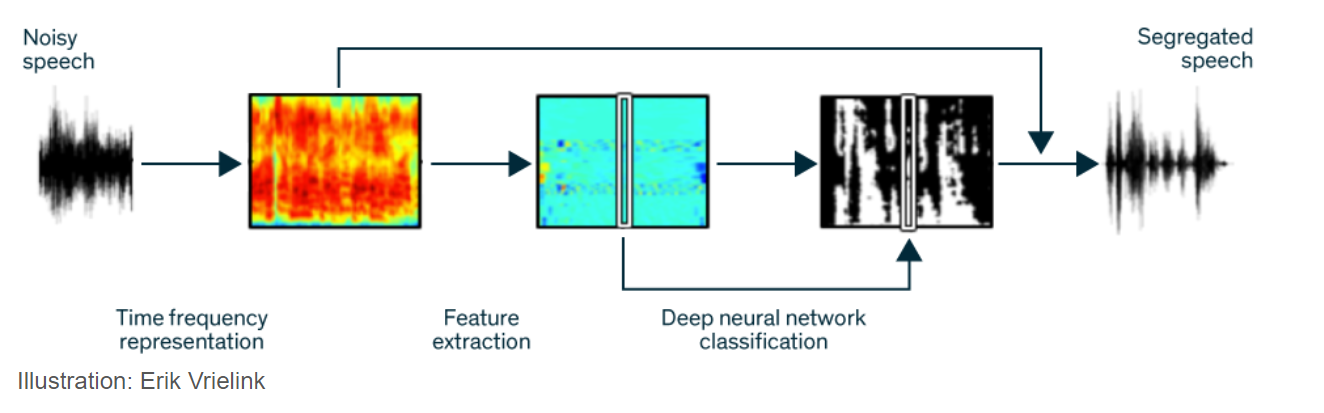

# Load Packages

In [2]:
print("Hello World!")

Hello World!


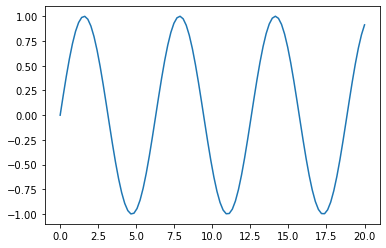

In [3]:


import numpy as np
import matplotlib.pyplot as plt
x = np.linspace(0, 20, 100)  # Create a list of evenly-spaced numbers over the range
plt.plot(x, np.sin(x))       # Plot the sine of each x point
plt.show()                   # Display the plot

In [4]:
#%tensorflow_version 1.x

In [5]:
import os
os.getcwd()
os.chdir('C:\\Users\\Admin\BAX_452')

In [6]:
import tensorflow as tf
print(tf.__version__)
tf.enable_eager_execution()

1.15.0



In [7]:
import matplotlib.image as mpimg

In [8]:
from os.path import isdir, join
from pathlib import Path
import pandas as pd

# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd

#%matplotlib inline

In [9]:
import sklearn
from sklearn.model_selection import train_test_split

In [10]:
import keras
import keras.layers as layers
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,AveragePooling2D,Dropout,BatchNormalization,Activation
from keras.models import Model,Input
from keras.optimizers import Adam

Using TensorFlow backend.


In [11]:
from tensorflow.contrib.framework.python.ops import audio_ops as contrib_audio

from tensorflow.contrib import signal

from keras.utils import to_categorical, plot_model


from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix

from keras.models import Sequential


from keras.models import Model
from keras.layers import Input, Dense

from keras.wrappers import scikit_learn


# Data Ingestion

    test "bed" audio

In [12]:
train_audio_path = 'C:\\Users\\Admin\\BAX_452\\train\\audio'
filename = '\\bed\\00f0204f_nohash_0.wav'
sample_rate, samples = wavfile.read(str(train_audio_path) + filename)

In [13]:
test_qudio_path = 'C:\\Users\\Admin\\BAX_452\\test\\audio'

    
    Sample rate is the number of samples of audio carried per second, measured in Hz.

In [14]:
print(sample_rate)
print(samples)

16000
[ -8 -11 -11 ...  13  10  16]


In [15]:
ipd.Audio(samples, rate=sample_rate)

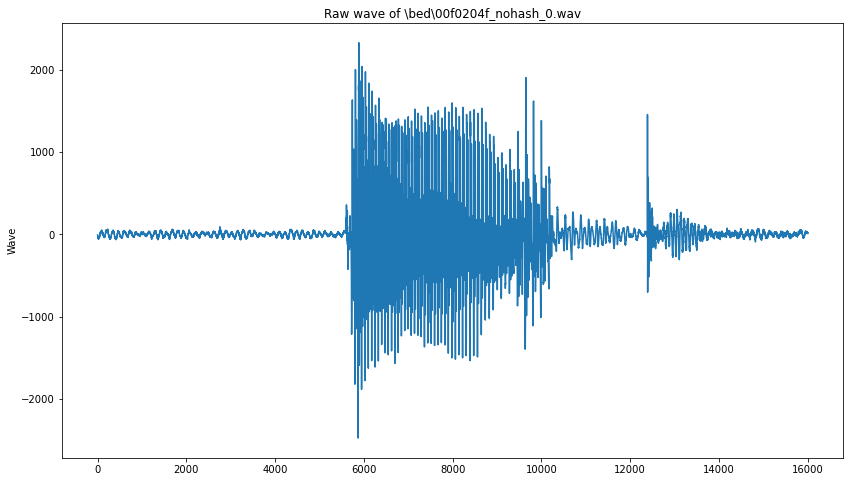

In [16]:
# visualize this audio wave:
fig = plt.figure(figsize=(14, 8))
plt.plot(samples)
plt.title('Raw wave of ' + filename)
plt.ylabel('Wave')
plt.show()


    
    collect all files and create "train" df to store the file names and labels

In [17]:
train_labels = os.listdir(train_audio_path)
file = []
labels = []
for label in train_labels:
    if label != '_background_noise_':
        files = os.listdir(train_audio_path + '\\' + label)
        for f in files:
            if f.endswith('wav'):
                file.append(f)
                labels.append(label)
    
train = pd.DataFrame({'file':file,'label':labels})

In [18]:
# test_audio_path = 'C:\\Users\\cheny\\BAX_452\\test\\audio'
# file_test = []
# files_test = os.listdir(test_audio_path)
# for f in files_test:
#     if f.endswith('wav'):
#         file_test.append(f)
    
# test = pd.DataFrame({'file':file_test})

In [19]:
train.head()

,file,label
0,00176480_nohash_0.wav,bed
1,004ae714_nohash_0.wav,bed
2,004ae714_nohash_1.wav,bed
3,00f0204f_nohash_0.wav,bed
4,00f0204f_nohash_1.wav,bed


# Data Processing -- Feature Engineering 

## Step 1: Spectrograms

    The spectrogram is a spectro-temporal representation of the sound. The horizontal direction of the spectrogram represents time, the vertical direction represents frequency. (1) 
    Spectrograms can be used as a way of visualizing the change of a nonstationary signal’s frequency content over time.
    The formula of spectrogram (2) is listed below:

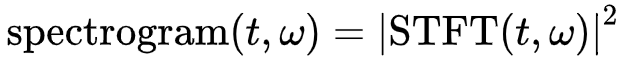

    The following spectrogram computation is educated by:
    https://www.tensorflow.org/api_guides/python/contrib.signal
    https://github.com/Tony607/tf_audio_signal/blob/master/tf_audio_signal.ipynb

In [20]:
def log_spectrogram(file, label):
    sample_rate, samples = wavfile.read(str(train_audio_path) + '\\'+label+'\\' + file)
    signals = tf.cast(tf.reshape(samples, [1,-1 ]),tf.float32) 
    spectrogram = signal.stft(signals, frame_length=1024, frame_step= 512)
    magnitude_spectrograms = tf.abs(spectrogram)
    log_offset = 1e-6
    #When compressing with a logarithm, it's a good idea to use a stabilizing offset 
    #to avoid high dynamic ranges caused by the singularity at zero.
    log_magnitude_spectrograms = tf.log(magnitude_spectrograms + log_offset)
    return log_magnitude_spectrograms

plot the log_spectrogram of sample data: bed


c:\ProgramData\Anaconda3\envs\tf15\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



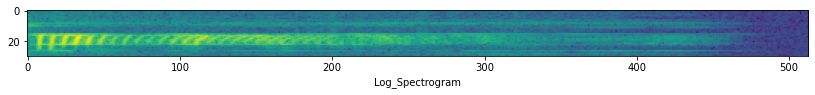

In [21]:
log_spe_bed = log_spectrogram(train.file[0],train.label[0]).numpy()
array_bed = log_spe_bed.astype(np.float)[0]
fig = plt.figure(figsize=(14,8))
#plt.ylabel("Freqs in Hz")
plt.xlabel("Log_Spectrogram")
plt.imshow(np.swapaxes(array_bed,0,1).T)

## Step 2: Mel Frequency Cepstral Coefficient (MFCC) 

    
    Mel Frequency Cepstral Coefficents (MFCCs) are a feature widely used in automatic speech and speaker recognition. The Mel scale relates perceived frequency, or pitch, of a pure tone to its actual measured frequency. Humans are much better at discerning small changes in pitch at low frequencies than they are at high frequencies. Incorporating this scale makes our features match more closely what humans hear. (3)

In [22]:
def mfcc(file=train['file'].tolist(), label=train['label'].tolist()):
    sample_rate, samples = wavfile.read(str(train_audio_path) + '\\'+label+'\\' + file)
    if len(samples) < 16000:
        samples = np.pad(samples, (0,16000-len(samples)), 'linear_ramp')
    else:
        samples = samples[:16000]
    signals = tf.cast(tf.reshape(samples, [1,-1 ]),tf.float32) 
    spectrogram = signal.stft(signals, frame_length=1024, frame_step= 512)
    magnitude_spectrograms = tf.abs(spectrogram)
    num_spectrogram_bins = magnitude_spectrograms.shape[-1].value
    lower_edge_hertz, upper_edge_hertz, num_mel_bins = 80.0, 7600.0, 64
    linear_to_mel_weight_matrix = tf.contrib.signal.linear_to_mel_weight_matrix(num_mel_bins, num_spectrogram_bins, sample_rate, lower_edge_hertz,upper_edge_hertz)
    mel_spectrograms = tf.tensordot(magnitude_spectrograms, linear_to_mel_weight_matrix, 1)
# Note: Shape inference for <a href="../../api_docs/python/tf/tensordot"><code>tf.tensordot</code></a> does not currently handle this case.
    mel_spectrograms.set_shape(magnitude_spectrograms.shape[:-1].concatenate(linear_to_mel_weight_matrix.shape[-1:]))
    log_offset = 1e-6
    log_mel_spectrograms = tf.log(mel_spectrograms + log_offset)
    num_mfccs = 13
# Keep the first `num_mfccs` MFCCs.
    mfccs = tf.contrib.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrograms)[..., :num_mfccs]
    return mfccs.numpy()[0]

In [23]:
mfcc_bed = mfcc(train.file[0],train.label[0])
#array_mfcc_bed = mfcc_bed.numpy()[0]

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



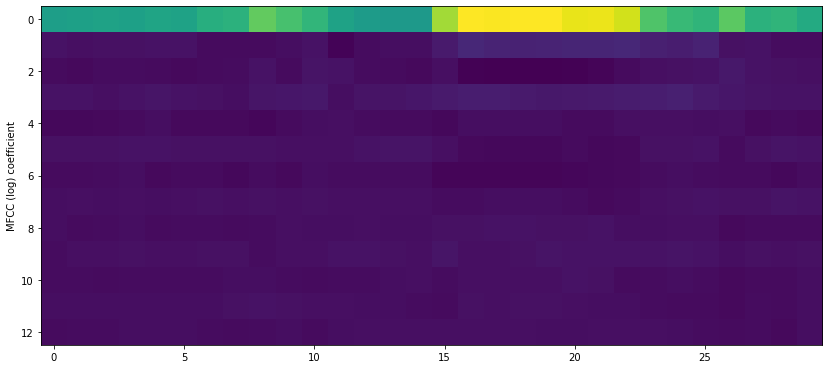

In [24]:
fig = plt.figure(figsize=(14,8))
#plt.xlabel("Freqs in Hz")
plt.ylabel("MFCC (log) coefficient")
plt.imshow(np.swapaxes(mfcc_bed,0,1))

In [25]:
def mfcc_test(file):
    sample_rate, samples = wavfile.read(str(test_audio_path) + '\\'+ file)
    if len(samples) < 16000:
        samples = np.pad(samples, (0,16000-len(samples)), 'linear_ramp')
    else:
        samples = samples[:16000]
    signals = tf.cast(tf.reshape(samples, [1,-1 ]),tf.float32) 
    spectrogram = signal.stft(signals, frame_length=1024, frame_step= 512)
    magnitude_spectrograms = tf.abs(spectrogram)
    num_spectrogram_bins = magnitude_spectrograms.shape[-1].value
    lower_edge_hertz, upper_edge_hertz, num_mel_bins = 80.0, 7600.0, 64
    linear_to_mel_weight_matrix = tf.contrib.signal.linear_to_mel_weight_matrix(num_mel_bins, num_spectrogram_bins, sample_rate, lower_edge_hertz,upper_edge_hertz)
    mel_spectrograms = tf.tensordot(magnitude_spectrograms, linear_to_mel_weight_matrix, 1)
    mel_spectrograms.set_shape(magnitude_spectrograms.shape[:-1].concatenate(linear_to_mel_weight_matrix.shape[-1:]))
    log_offset = 1e-6
    log_mel_spectrograms = tf.log(mel_spectrograms + log_offset)
    num_mfccs = 13
    mfccs = tf.contrib.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrograms)[..., :num_mfccs]
    return mfccs.numpy()[0]

# Data Modeling

## Data Split 

In [26]:
train.head()

,file,label
0,00176480_nohash_0.wav,bed
1,004ae714_nohash_0.wav,bed
2,004ae714_nohash_1.wav,bed
3,00f0204f_nohash_0.wav,bed
4,00f0204f_nohash_1.wav,bed


    
    Create Training Data

In [27]:
# X_train
X_train = train.apply(lambda train: mfcc(train['file'], train['label']), axis=1)

X_train_array_all = np.vstack(X_train.values).reshape(64721,30,13)

In [28]:
# Y_train
Y_train = labels

In [29]:
#Categorize labels
y_train_array_all = to_categorical(pd.Series(Y_train,dtype='category').cat.codes.values)

    
    Create a table to compare Y labels and the categorized Y labels

In [30]:
categories_code = pd.DataFrame({'name' : Y_train, 'code' : pd.Series(Y_train,dtype='category').cat.codes.values})

In [31]:
compare_categories = categories_code.drop_duplicates(inplace=False)

In [32]:
compare_categories

,name,code
0,bed,0
1713,bird,1
3444,cat,2
5177,dog,3
6923,down,4
9282,eight,5
11634,five,6
13991,four,7
16363,go,8
18735,happy,9


    
    Split Data

In [33]:
X_train_array, X_test_array, y_train_array, y_test_array = train_test_split(X_train_array_all, y_train_array_all, test_size=0.1, random_state=42)

    
    keras has a class_weight paramter in the fit() function that will give higher penalties to missclassifications in underrepresented classes. It takes a dict like this (4):
    
    (The following code is adoppted from: https://github.com/chrisdinant/speech/blob/master/train.ipynb)

In [34]:
def get_class_weights(y):
    counter = Counter(y)
    majority = max(counter.values())
    return  {cls: float(majority/count) for cls, count in counter.items()}  

class_weights = get_class_weights(pd.Series(Y_train,dtype='category').cat.codes.values)

## Create a test sample -- "Left" Voice

In [35]:
test_audio_path = 'C:\\Users\\Admin\\BAX_452\\test\\audio\\'
april_test_filename = 'clip_52282b6ae.wav'
april_sample_rate, april_samples = wavfile.read(str(test_audio_path) + april_test_filename)

In [36]:
april_test_audio_path = 'C:\\Users\\Admin\\BAX_452\\test\\audio\\'
april_test_filename = 'clip_52282b6ae.wav'
april_sample_rate, april_samples = wavfile.read(str(april_test_audio_path) + april_test_filename)

In [37]:
ipd.Audio(april_samples, rate=april_sample_rate)

c:\ProgramData\Anaconda3\envs\tf15\lib\site-packages\IPython\lib\display.py:174: RuntimeWarning:

invalid value encountered in true_divide



In [38]:
mfcc_april_test = mfcc_test(april_test_filename).reshape(1,30,13)


## Create Keras Sequential Model

In [63]:
model = Sequential()


    
    Here we create a sequential model. This tells keras to stack all layers sequentially.

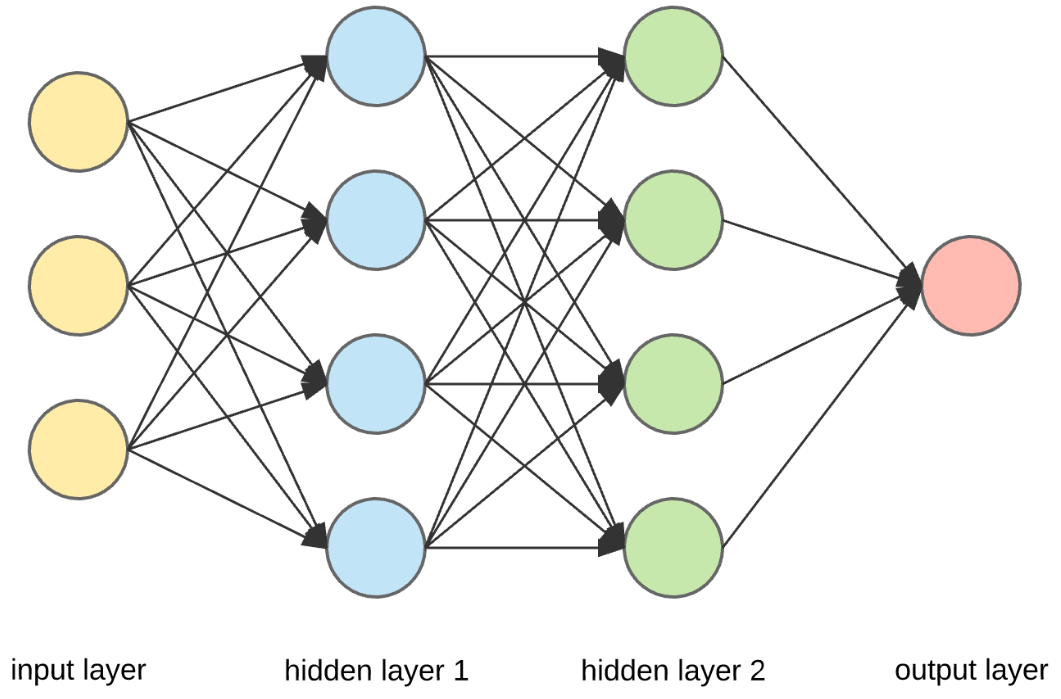

In [64]:
# Dense(64) is a fully-connected layer with 64 hidden units.
# in the first layer, you must specify the expected input data shape:
# here, 20-dimensional vectors.
with tf.Session() as sess0:
    assert not tf.executing_eagerly()
    model = Sequential()

    model.add(layers.Dense(32, input_shape=X_train_array.shape[1:], activation='tanh'))
  #  model.add(Dropout(0.5))
    model.add(Dense(64, activation='tanh'))
   # model.add(Dropout(0.5))
    model.add(Dense(128, activation='tanh'))
   # model.add(Dropout(0.5))
    
    model.add(Flatten())
    #model.add(Dense(256, activation='relu'))

    model.add(Dense(30))
    #model.add(Activation('sigmoid'))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    #Adam, an algorithm for first-order gradient-based optimization of stochastic objective functions, based on adaptive estimates of lower-order moments.
    model.summary()
    
    #history = model.fit(x=X_train_array, y=y_train_array, epochs=5, verbose=1, validation_split = 0.33, shuffle=True, class_weight=get_class_weights(pd.Series((list(set(labels))),dtype='category').cat.codes.values),batch_size=128) 
    history = model.fit(x=X_train_array, y=y_train_array, epochs=25, verbose=1, validation_split = 0.1, shuffle=True, class_weight=get_class_weights(pd.Series(Y_train,dtype='category').cat.codes.values),batch_size=128) 
    
    model_evaluation = model.evaluate(x=X_test_array, y=y_test_array, batch_size=None, verbose=1)

    prediction = model.predict(X_test_array, batch_size = 128, verbose = 1)
    
    april_tst = model.predict(mfcc_april_test, batch_size = 128, verbose = 1)

    sess0.close()


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30, 32)            448       
_________________________________________________________________
dense_2 (Dense)              (None, 30, 64)            2112      
_________________________________________________________________
dense_3 (Dense)              (None, 30, 128)           8320      
_________________________________________________________________
flatten_1 (Flatten)          (None, 3840)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 30)                115230    
_________________________________________________________________
activation_1 (Activation)    (None, 30)                0         
Total params: 126,110
Trainable params

## New models

In [75]:
# Dense(64) is a fully-connected layer with 64 hidden units.
# in the first layer, you must specify the expected input data shape:
# here, 20-dimensional vectors.
with tf.Session() as sess0:
    assert not tf.executing_eagerly()
    model = Sequential()

    model.add(layers.Dense(64, input_shape=X_train_array.shape[1:], activation='tanh'))
  #  model.add(Dropout(0.5))
    model.add(Dense(48, activation='tanh'))
   # model.add(Dropout(0.5))
    model.add(Dense(32, activation='tanh'))
   # model.add(Dropout(0.5))
    
    model.add(Flatten())
    #model.add(Dense(256, activation='relu'))

    model.add(Dense(30))
    #model.add(Activation('sigmoid'))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    #Adam, an algorithm for first-order gradient-based optimization of stochastic objective functions, based on adaptive estimates of lower-order moments.
    model.summary()
    
    #history = model.fit(x=X_train_array, y=y_train_array, epochs=5, verbose=1, validation_split = 0.33, shuffle=True, class_weight=get_class_weights(pd.Series((list(set(labels))),dtype='category').cat.codes.values),batch_size=128) 
    history = model.fit(x=X_train_array, y=y_train_array, epochs=45, verbose=1, validation_split = 0.1, shuffle=True, class_weight=get_class_weights(pd.Series(Y_train,dtype='category').cat.codes.values),batch_size=256) 
    
    model_evaluation = model.evaluate(x=X_test_array, y=y_test_array, batch_size=None, verbose=1)

    prediction = model.predict(X_test_array, batch_size = 256, verbose = 1)
    
    april_tst = model.predict(mfcc_april_test, batch_size = 256, verbose = 1)

    sess0.close()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 30, 64)            896       
_________________________________________________________________
dense_41 (Dense)             (None, 30, 48)            3120      
_________________________________________________________________
dense_42 (Dense)             (None, 30, 32)            1568      
_________________________________________________________________
flatten_9 (Flatten)          (None, 960)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 30)                28830     
_________________________________________________________________
activation_9 (Activation)    (None, 30)                0         
Total params: 34,414
Trainable params: 34,414
Non-trainable params: 0
__________________________________________________

In [137]:
# Dense(64) is a fully-connected layer with 64 hidden units.
# in the first layer, you must specify the expected input data shape:
# here, 20-dimensional vectors.
with tf.Session() as sess0:
    assert not tf.executing_eagerly()
    model = Sequential()

    model.add(layers.Dense(64, input_shape=X_train_array.shape[1:], activation='tanh'))
  #  model.add(Dropout(0.5))
    model.add(Dense(48, activation='tanh'))
   # model.add(Dropout(0.5))
    model.add(Dense(32, activation='tanh'))
   # model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(30))
    #model.add(Activation('sigmoid'))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    #Adam, an algorithm for first-order gradient-based optimization of stochastic objective functions, based on adaptive estimates of lower-order moments.
    model.summary()
    
    #history = model.fit(x=X_train_array, y=y_train_array, epochs=5, verbose=1, validation_split = 0.33, shuffle=True, class_weight=get_class_weights(pd.Series((list(set(labels))),dtype='category').cat.codes.values),batch_size=128) 
    history = model.fit(x=X_train_array, y=y_train_array, epochs=45, verbose=1, validation_split = 0.1, shuffle=True, class_weight=get_class_weights(pd.Series(Y_train,dtype='category').cat.codes.values),batch_size=256) 
    
    model_evaluation = model.evaluate(x=X_test_array, y=y_test_array, batch_size=None, verbose=1)

    prediction = model.predict(X_test_array, batch_size = 256, verbose = 1)
    
    april_tst = model.predict(mfcc_april_test, batch_size = 256, verbose = 1)

    sess0.close()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_114 (Dense)            (None, 30, 64)            896       
_________________________________________________________________
dense_115 (Dense)            (None, 30, 48)            3120      
_________________________________________________________________
dense_116 (Dense)            (None, 30, 32)            1568      
_________________________________________________________________
flatten_24 (Flatten)         (None, 960)               0         
_________________________________________________________________
dense_117 (Dense)            (None, 128)               123008    
_________________________________________________________________
dropout_22 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_118 (Dense)            (None, 30)              

In [133]:
# Dense(64) is a fully-connected layer with 64 hidden units.
# in the first layer, you must specify the expected input data shape:
# here, 20-dimensional vectors.
with tf.Session() as sess0:
    assert not tf.executing_eagerly()
    model = Sequential()

    model.add(layers.Dense(32, input_shape=X_train_array.shape[1:], activation='tanh'))
  #  model.add(Dropout(0.5))
    model.add(Dense(64, activation='tanh'))
   # model.add(Dropout(0.5))
    model.add(Dense(128, activation='tanh'))
   # model.add(Dropout(0.5))
    
    model.add(Flatten())
    #model.add(Dense(256, activation='relu'))

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(30))
    #model.add(Activation('sigmoid'))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    #Adam, an algorithm for first-order gradient-based optimization of stochastic objective functions, based on adaptive estimates of lower-order moments.
    model.summary()
    
    #history = model.fit(x=X_train_array, y=y_train_array, epochs=5, verbose=1, validation_split = 0.33, shuffle=True, class_weight=get_class_weights(pd.Series((list(set(labels))),dtype='category').cat.codes.values),batch_size=128) 
    history = model.fit(x=X_train_array, y=y_train_array, epochs=25, verbose=1, validation_split = 0.1, shuffle=True, class_weight=get_class_weights(pd.Series(Y_train,dtype='category').cat.codes.values),batch_size=128) 
    
    model_evaluation = model.evaluate(x=X_test_array, y=y_test_array, batch_size=None, verbose=1)

    prediction = model.predict(X_test_array, batch_size = 128, verbose = 1)
    
    april_tst = model.predict(mfcc_april_test, batch_size = 128, verbose = 1)

    sess0.close()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_109 (Dense)            (None, 30, 32)            448       
_________________________________________________________________
dense_110 (Dense)            (None, 30, 64)            2112      
_________________________________________________________________
dense_111 (Dense)            (None, 30, 128)           8320      
_________________________________________________________________
flatten_23 (Flatten)         (None, 3840)              0         
_________________________________________________________________
dense_112 (Dense)            (None, 128)               491648    
_________________________________________________________________
dropout_21 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_113 (Dense)            (None, 30)              

In [153]:
# Dense(64) is a fully-connected layer with 64 hidden units.
# in the first layer, you must specify the expected input data shape:
# here, 20-dimensional vectors.
with tf.Session() as sess0:
    assert not tf.executing_eagerly()
    model = Sequential()

    model.add(layers.Dense(64, input_shape=X_train_array.shape[1:], activation='relu'))
   # model.add(Dropout(0.5))
    model.add(Dense(48, activation='relu'))
   # model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    #model.add(Dense(256, activation='relu'))

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(30))
    #model.add(Activation('sigmoid'))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    #Adam, an algorithm for first-order gradient-based optimization of stochastic objective functions, based on adaptive estimates of lower-order moments.
    model.summary()
    
    #history = model.fit(x=X_train_array, y=y_train_array, epochs=5, verbose=1, validation_split = 0.33, shuffle=True, class_weight=get_class_weights(pd.Series((list(set(labels))),dtype='category').cat.codes.values),batch_size=128) 
    history = model.fit(x=X_train_array, y=y_train_array, epochs=45, verbose=1, validation_split = 0.1, shuffle=True, class_weight=get_class_weights(pd.Series(Y_train,dtype='category').cat.codes.values),batch_size=128) 
    
    model_evaluation = model.evaluate(x=X_test_array, y=y_test_array, batch_size=None, verbose=1)

    prediction = model.predict(X_test_array, batch_size = 128, verbose = 1)
    
    april_tst = model.predict(mfcc_april_test, batch_size = 128, verbose = 1)

    sess0.close()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_134 (Dense)            (None, 30, 64)            896       
_________________________________________________________________
dense_135 (Dense)            (None, 30, 48)            3120      
_________________________________________________________________
dense_136 (Dense)            (None, 30, 32)            1568      
_________________________________________________________________
dropout_29 (Dropout)         (None, 30, 32)            0         
_________________________________________________________________
flatten_28 (Flatten)         (None, 960)               0         
_________________________________________________________________
dense_137 (Dense)            (None, 128)               123008    
_________________________________________________________________
dropout_30 (Dropout)         (None, 128)             

In [165]:
# Dense(64) is a fully-connected layer with 64 hidden units.
# in the first layer, you must specify the expected input data shape:
# here, 20-dimensional vectors.
with tf.Session() as sess0:
    assert not tf.executing_eagerly()
    model = Sequential()

    model.add(layers.Dense(64, input_shape=X_train_array.shape[1:], activation='relu'))
   # model.add(Dropout(0.5))
    model.add(Dense(48, W_regularizer=l2(l2_lambda) ,activation='relu'))
   # model.add(Dropout(0.5))
    model.add(Dense(32, W_regularizer=l2(l2_lambda) , activation='relu'))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    #model.add(Dense(256, activation='relu'))

    model.add(Dense(128, W_regularizer=l2(l2_lambda) ,activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(30))
    #model.add(Activation('sigmoid'))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    #Adam, an algorithm for first-order gradient-based optimization of stochastic objective functions, based on adaptive estimates of lower-order moments.
    model.summary()
    
    #history = model.fit(x=X_train_array, y=y_train_array, epochs=5, verbose=1, validation_split = 0.33, shuffle=True, class_weight=get_class_weights(pd.Series((list(set(labels))),dtype='category').cat.codes.values),batch_size=128) 
    history = model.fit(x=X_train_array, y=y_train_array, epochs=45, verbose=1, validation_split = 0.1, shuffle=True, class_weight=get_class_weights(pd.Series(Y_train,dtype='category').cat.codes.values),batch_size=128) 
    
    model_evaluation = model.evaluate(x=X_test_array, y=y_test_array, batch_size=None, verbose=1)

    prediction = model.predict(X_test_array, batch_size = 128, verbose = 1)
    
    april_tst = model.predict(mfcc_april_test, batch_size = 128, verbose = 1)

    sess0.close()

c:\ProgramData\Anaconda3\envs\tf15\lib\site-packages\ipykernel_launcher.py:10: UserWarning:

Update your `Dense` call to the Keras 2 API: `Dense(48, activation="relu", kernel_regularizer=<keras.reg...)`

c:\ProgramData\Anaconda3\envs\tf15\lib\site-packages\ipykernel_launcher.py:12: UserWarning:

Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_regularizer=<keras.reg...)`

c:\ProgramData\Anaconda3\envs\tf15\lib\site-packages\ipykernel_launcher.py:18: UserWarning:

Update your `Dense` call to the Keras 2 API: `Dense(128, activation="relu", kernel_regularizer=<keras.reg...)`



TypeError: add() got an unexpected keyword argument 'W_regularizer'

## Analysis

In [163]:
score = model_evaluation[1]
score
# loss value & metrics values for the model in test mode

0.8362428545951843

In [158]:
print(history.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


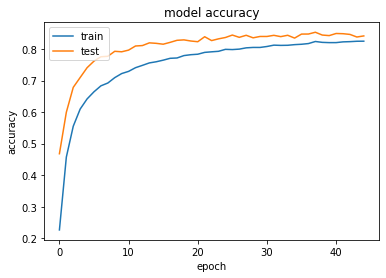

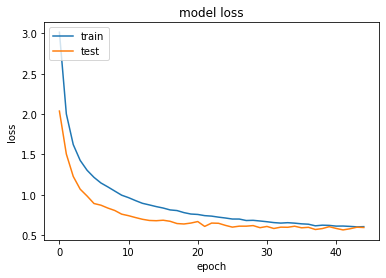

In [164]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Test "Left" voice 

In [132]:
np.argmax(april_tst)

17

In [90]:
compare_categories

,name,code
0,bed,0
1713,bird,1
3444,cat,2
5177,dog,3
6923,down,4
9282,eight,5
11634,five,6
13991,four,7
16363,go,8
18735,happy,9


# Conclusion 

    1. Audio file is usually converted to array to be the input of Keras model.
    2. Spectrogram and MFCC are the two important features of audio files to be converted to arrays.
    3. We can modify the layers of Keras model to increase the model accuracy.
    4. Be aware of overfitting problems by comparing training and testing accuracies in the Keras model.
    5. Sequential model is easier to modify, compared with Keras API model.

# Improvements 

    
    1. To accurately predict the voices with noises in the "test" auodio file in Kaggle dataset, I need to process current training data by adding background noise.
    2. Since there are unknown voices in the Kaggle "test" audio file, I also need to add "unknown" as one of my labels.
    3. I can also normalize the mfccs of training data to see if I can improve the model accuracy.
    4. I can also use the combination of CNN and RNN to see if I can improve the model accuracy or not.
     

# Reference

1.http://www.fon.hum.uva.nl/praat/manual/Intro_3_1__Viewing_a_spectrogram.html

2.https://en.wikipedia.org/wiki/Short-time_Fourier_transform

3.http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/

4.https://github.com/chrisdinant/speech/blob/master/train.ipynb

# Acknowledgements

1.https://www.kaggle.com/davids1992/speech-representation-and-data-exploration

2.https://www.kaggle.com/ollmer/labels-spectrograms-exploration

3.https://github.com/Tony607/tf_audio_signal/blob/master/tf_audio_signal.ipynb

4.https://towardsdatascience.com/kaggle-tensorflow-speech-recognition-challenge-b46a3bca2501

5.https://www.kaggle.com/kcs93023/keras-sequential-conv1d-model-classification